In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
data = pd.read_csv('C:/Users/19054/Desktop/mlp/GOOG1.csv')
print(data.info())
data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1763 non-null   object 
 1   Open       1763 non-null   float64
 2   High       1763 non-null   float64
 3   Low        1763 non-null   float64
 4   Close      1763 non-null   float64
 5   Adj Close  1763 non-null   float64
 6   Volume     1763 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 96.5+ KB
None


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-29,507.647217,516.533875,504.857666,516.185181,516.185181,3222000
1,2013-10-30,516.778015,516.817810,511.084320,513.286072,513.286072,2658000
2,2013-10-31,512.543884,518.815369,510.073120,513.365784,513.365784,3292200
3,2013-11-01,513.968506,516.065674,510.636017,511.602386,511.602386,2576100
4,2013-11-04,513.824036,514.257446,509.106750,511.139130,511.139130,2286000
...,...,...,...,...,...,...,...
1758,2020-10-22,1593.050049,1621.989990,1585.000000,1615.329956,1615.329956,1433600
1759,2020-10-23,1626.069946,1642.359985,1620.510010,1641.000000,1641.000000,1375800
1760,2020-10-26,1625.010010,1638.239990,1576.500000,1590.449951,1590.449951,1853300
1761,2020-10-27,1595.670044,1606.844971,1582.780029,1604.260010,1604.260010,1229000


In [3]:
# Select features (columns) to be involved intro training and predictions
columns = list(data)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(data['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(data.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(columns))

Training set shape == (1763, 7)
All timestamps == 1763
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


In [4]:
import pandas as pd
data = data[columns].astype(str)
for i in columns:
    for j in range(0, len(data)):
        data[i][j] = data[i][j].replace(',', '')

data = data.astype(float)

# Using multiple features (predictors)
training_set = data.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1763, 5).


array([[ 507.647217,  516.533875,  504.857666,  516.185181,  516.185181],
       [ 516.778015,  516.81781 ,  511.08432 ,  513.286072,  513.286072],
       [ 512.543884,  518.815369,  510.07312 ,  513.365784,  513.365784],
       ...,
       [1625.01001 , 1638.23999 , 1576.5     , 1590.449951, 1590.449951],
       [1595.670044, 1606.844971, 1582.780029, 1604.26001 , 1604.26001 ],
       [1559.73999 , 1561.349976, 1514.619995, 1516.619995, 1516.619995]])

In [5]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.33524898],
       [-1.30521508],
       [-1.31914239],
       ...,
       [ 2.34008812],
       [ 2.24358028],
       [ 2.1253957 ]])

In [6]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1614, 90, 4).
y_train shape == (1614, 1).


In [77]:
X_train, y_train

(array([[[-1.33524898, -1.31618744, -1.33059191, -1.30543132],
         [-1.30521508, -1.31526591, -1.30988906, -1.3149472 ],
         [-1.31914239, -1.3087827 , -1.31325117, -1.31468556],
         ...,
         [-1.00233724, -1.01028736, -0.99089915, -1.00561298],
         [-0.9949311 , -1.00892943, -1.00275782, -1.0134939 ],
         [-1.01313506, -1.02404575, -1.01493104, -1.0187588 ]],
 
        [[-1.30521508, -1.31526591, -1.30988906, -1.3149472 ],
         [-1.31914239, -1.3087827 , -1.31325117, -1.31468556],
         [-1.31445639, -1.31770701, -1.31137961, -1.32047364],
         ...,
         [-0.9949311 , -1.00892943, -1.00275782, -1.0134939 ],
         [-1.01313506, -1.02404575, -1.01493104, -1.0187588 ],
         [-1.01628101, -1.02941329, -1.02726985, -1.03769259]],
 
        [[-1.31914239, -1.3087827 , -1.31325117, -1.31468556],
         [-1.31445639, -1.31770701, -1.31137961, -1.32047364],
         [-1.31493159, -1.32357573, -1.31646423, -1.32199421],
         ...,
       

In [67]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

# Initializing the Neural Network based on LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=True,  input_shape=(n_past, data.shape[1]-1)))
model.add(LSTM(units=10,  return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error', metrics = ['mean_absolute_error', ''])

In [68]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True,
                      save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle= True, epochs=30,  callbacks=[es, rlr, mcp, tb],
                    validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 0.8027 - mean_absolute_error: 0.7183
Epoch 00001: val_loss improved from inf to 0.88948, saving model to weights.h5
6/6 [==============================] - 2s 403ms/step - loss: 0.8027 - mean_absolute_error: 0.7183 - val_loss: 0.8895 - val_mean_absolute_error: 0.8228 - lr: 0.0100
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 0.5236 - mean_absolute_error: 0.5782
Epoch 00002: val_loss did not improve from 0.88948
6/6 [==============================] - 1s 142ms/step - loss: 0.5236 - mean_absolute_error: 0.5782 - val_loss: 0.9109 - val_mean_absolute_error: 0.8347 - lr: 0.0100
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.5067 - mean_absolute_error: 0.5704
Epoch 00003: val_loss improved from 0.88948 to 0.86530, saving model to weights.h5
6/6 [==============================] - 1s 176ms/step - loss: 0.5067 - mean_absolute_error: 0.5704 - val_loss: 0.8653 - val_mean_absolute_error: 0.8093

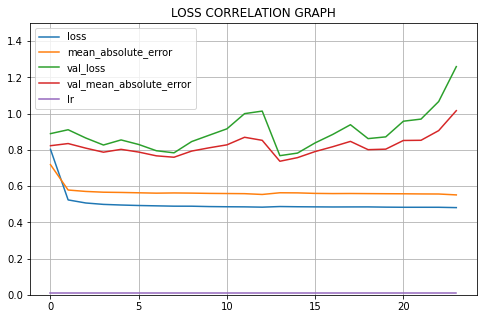

In [78]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('LOSS CORRELATION GRAPH')
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 90, 64)            17664     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                3000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 20,675
Trainable params: 20,675
Non-trainable params: 0
_________________________________________________________________


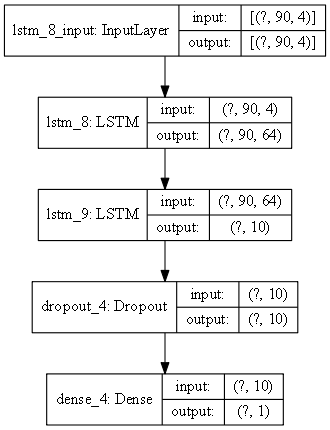

In [76]:
import tensorflow as tf
model.summary()
tf.keras.utils.plot_model(
    model, to_file='fd.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=80
)

In [27]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [28]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [29]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):

    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2014-10-10,576.559082
2014-10-13,578.260559
2014-10-14,579.975159


In [30]:
PREDICTION_TRAIN.index

DatetimeIndex(['2014-10-10', '2014-10-13', '2014-10-14', '2014-10-15',
               '2014-10-16', '2014-10-17', '2014-10-20', '2014-10-21',
               '2014-10-22', '2014-10-23',
               ...
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-26',
               '2020-10-27', '2020-10-28'],
              dtype='datetime64[ns]', length=1524, freq=None)

In [31]:
PREDICTIONS_FUTURE

,Open
2020-10-28,1078.710693
2020-10-29,1078.288330
2020-10-30,1078.576294
2020-10-31,1078.921509
2020-11-01,1078.703857
2020-11-02,1078.334839
2020-11-03,1078.038574
2020-11-04,1077.503174
2020-11-05,1077.131104
2020-11-06,1076.929077


In [32]:
PREDICTIONS_FUTURE['Open']

2020-10-28    1078.710693
2020-10-29    1078.288330
2020-10-30    1078.576294
2020-10-31    1078.921509
2020-11-01    1078.703857
2020-11-02    1078.334839
2020-11-03    1078.038574
2020-11-04    1077.503174
2020-11-05    1077.131104
2020-11-06    1076.929077
2020-11-07    1076.345581
2020-11-08    1076.272949
2020-11-09    1076.206421
2020-11-10    1075.906250
2020-11-11    1075.713745
2020-11-12    1075.479614
2020-11-13    1075.279907
2020-11-14    1075.467529
2020-11-15    1075.360474
2020-11-16    1075.148315
2020-11-17    1074.756470
2020-11-18    1074.400391
2020-11-19    1074.935303
2020-11-20    1075.144287
2020-11-21    1075.415649
2020-11-22    1074.905884
2020-11-23    1074.644043
2020-11-24    1074.674805
2020-11-25    1074.737549
2020-11-26    1074.666504
2020-11-27    1074.289795
2020-11-28    1074.359985
2020-11-29    1074.564575
2020-11-30    1075.401855
2020-12-01    1075.940552
2020-12-02    1075.741333
2020-12-03    1075.302490
2020-12-04    1074.587891
2020-12-05  

In [35]:
START_DATE_FOR_PLOTTING = '2013-10-29'

In [36]:
PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index

DatetimeIndex(['2014-10-10', '2014-10-13', '2014-10-14', '2014-10-15',
               '2014-10-16', '2014-10-17', '2014-10-20', '2014-10-21',
               '2014-10-22', '2014-10-23',
               ...
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-26',
               '2020-10-27', '2020-10-28'],
              dtype='datetime64[ns]', length=1524, freq=None)

In [37]:
PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open']

2014-10-10     576.559082
2014-10-13     578.260559
2014-10-14     579.975159
2014-10-15     581.894897
2014-10-16     583.725342
                 ...     
2020-10-22    1071.924194
2020-10-23    1071.943481
2020-10-26    1072.354248
2020-10-27    1072.639771
2020-10-28    1072.946289
Name: Open, Length: 1524, dtype: float32

In [38]:
data.loc[START_DATE_FOR_PLOTTING:].index

DatetimeIndex(['2013-10-29', '2013-10-30', '2013-10-31', '2013-11-01',
               '2013-11-04', '2013-11-05', '2013-11-06', '2013-11-07',
               '2013-11-08', '2013-11-11',
               ...
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-26',
               '2020-10-27', '2020-10-28'],
              dtype='datetime64[ns]', length=1763, freq=None)

In [39]:
data.loc[START_DATE_FOR_PLOTTING:]['Open']

2013-10-29     507.647217
2013-10-30     516.778015
2013-10-31     512.543884
2013-11-01     513.968506
2013-11-04     513.824036
                 ...     
2020-10-22    1593.050049
2020-10-23    1626.069946
2020-10-26    1625.010010
2020-10-27    1595.670044
2020-10-28    1559.739990
Name: Open, Length: 1763, dtype: float64

In [40]:
#Parse training set timestamp for better visualization
data = pd.DataFrame(data, columns=columns)
data.index = datelist_train
data.index = pd.to_datetime(data.index)

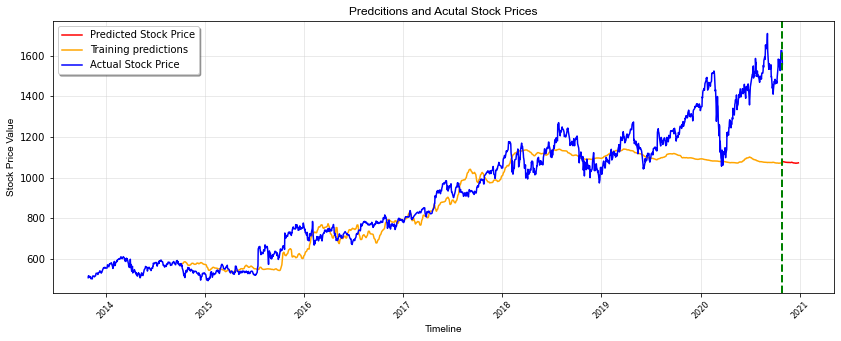

<Figure size 1008x360 with 0 Axes>

In [43]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2013-10-29'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(data.loc[START_DATE_FOR_PLOTTING:].index, data.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45,  fontsize=8)
plt.show()
plt.savefig('predictions_actual.jpeg')